2022-09-06 16:23:36.177653: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-06 16:23:36.181589: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-06 16:23:36.182062: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-06 16:23:36.182701: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

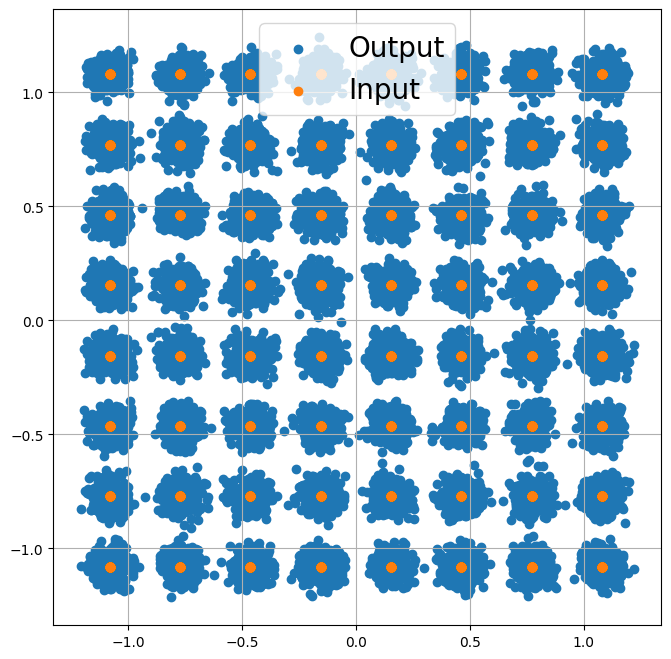

In [1]:
'''
@file tutorial.py
@author Sciroccogti (scirocco_gti@yeah.net)
@brief 
@date 2022-09-05 20:40:03
@modified: 2022-09-05 20:41:17
'''
# Import TensorFlow and NumPy
from tensorflow.keras.layers import Dense, Layer
from tensorflow.keras import Model
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# For plotting
%matplotlib inline

# For saving complex Python data structures efficiently

# For the implementation of the neural receiver

# Binary source to generate uniform i.i.d. bits
binary_source = sn.utils.BinarySource()

# 256-QAM constellation
NUM_BITS_PER_SYMBOL = 6
# The constellation is set to be trainable
constellation = sn.mapping.Constellation(
    "qam", NUM_BITS_PER_SYMBOL, trainable=True)

# Mapper and demapper
mapper = sn.mapping.Mapper(constellation=constellation)
demapper = sn.mapping.Demapper("app", constellation=constellation)

# AWGN channel
awgn_channel = sn.channel.AWGN()

BATCH_SIZE = 128  # How many examples are processed by Sionna in parallel
EBN0_DB = 17.0  # Eb/N0 in dB

no = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                        num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                        coderate=1.0)  # Coderate set to 1 as we do uncoded transmission here

bits = binary_source([BATCH_SIZE,
                      1200])  # Blocklength
x = mapper(bits)
y = awgn_channel([x, no])
llr = demapper([y, no])

plt.figure(figsize=(8, 8))
plt.axes().set_aspect(1.0)
plt.grid(True)
plt.scatter(tf.math.real(y), tf.math.imag(y), label='Output')
plt.scatter(tf.math.real(x), tf.math.imag(x), label='Input')
plt.legend(fontsize=20)


In [7]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

print(f"BCE: {bce(bits, llr)}")

with tf.GradientTape() as tape:
    bits = binary_source([BATCH_SIZE, 1200])  # Blocklength
    x = mapper(bits)
    y = awgn_channel([x, no])
    llr = demapper([y, no])
    loss = bce(bits, llr)
    print(loss)

gradient = tape.gradient(loss, tape.watched_variables())

for g in gradient:
    print(g.shape)

BCE: 0.0003187312977388501
tf.Tensor(0.00013062943, shape=(), dtype=float32)
(2, 64)


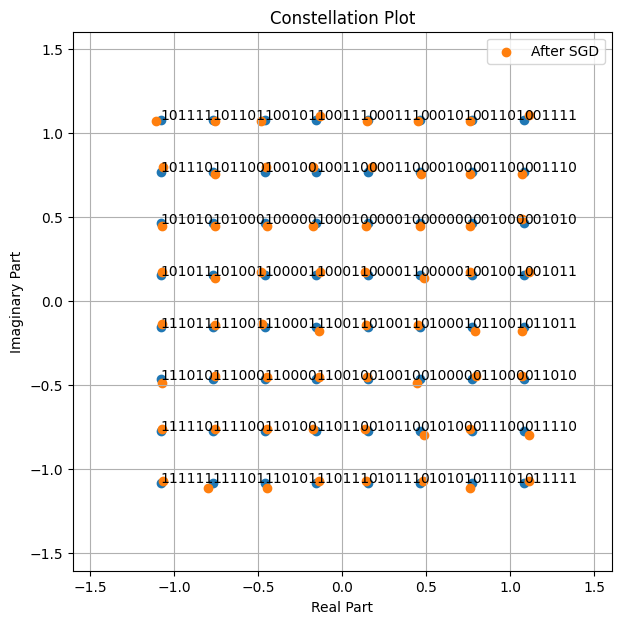

In [4]:
optimizer = tf.keras.optimizers.Adam(1e-2)
optimizer.apply_gradients(zip(gradient, tape.watched_variables()))
fig = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL).show()
fig.axes[0].scatter(tf.math.real(constellation.points), tf.math.imag(constellation.points), label='After SGD')
fig.axes[0].legend();

tf.Tensor(0.00012092074, shape=(), dtype=float32)


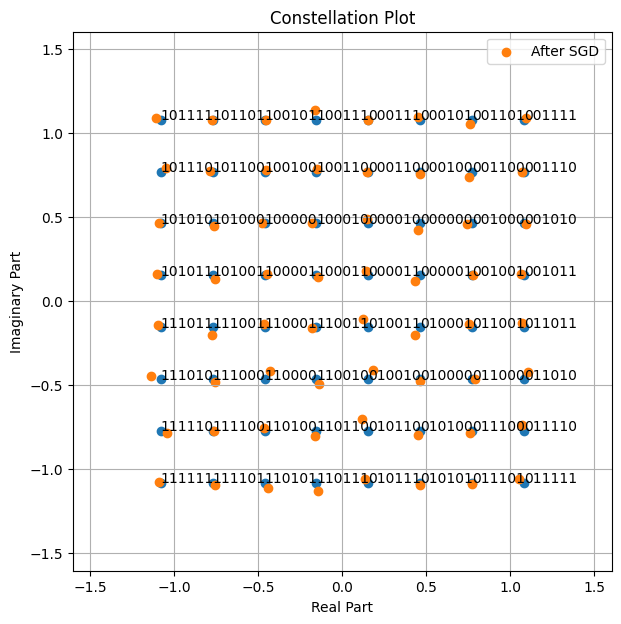

In [22]:
with tf.GradientTape() as tape:
    bits = binary_source([BATCH_SIZE, 1200])  # Blocklength
    x = mapper(bits)
    y = awgn_channel([x, no])
    llr = demapper([y, no])
    loss = bce(bits, llr)
    print(loss)

gradient = tape.gradient(loss, tape.watched_variables())
optimizer = tf.keras.optimizers.Adam(1e-2)
optimizer.apply_gradients(zip(gradient, tape.watched_variables()))
fig = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL).show()
fig.axes[0].scatter(tf.math.real(constellation.points), tf.math.imag(constellation.points), label='After SGD')
fig.axes[0].legend();